In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
# Add the project root (toy-wm directory) to sys.path so we can import src as a package
# This allows relative imports within the package to work correctly
# Assumes notebook is run from the project root directory
project_root = os.getcwd()  # or use: os.path.dirname(os.path.abspath(''))
print(project_root)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

/share/u/wendler/code/toy-wm


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch as t

# Import using absolute path from src package
from src.utils.checkpoint import load_model_from_config

#model = load_model_from_config("configs/small_6frame.yaml")
model = load_model_from_config("configs/bigger_30frame_causal.yaml", strict=False)
model.eval()

loading configs/bigger_30frame_causal.yaml


CausalDit(
  (rope_seq): RoPE()
  (blocks): ModuleList(
    (0-7): 8 x CausalBlock(
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (selfattn): AttentionEinOps(
        (rope): RoPE()
        (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
      (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (geglu): GEGLU(
        (up_proj): Linear(in_features=384, out_features=1536, bias=True)
        (up_gate): Linear(in_features=384, out_features=1536, bias=True)
        (down): Linear(in_features=1536, out_features=384, bias=True)
        (nonlin): SiLU()
      )
      (modulation): Sequential(
        (0): SiLU()
        (1): Linear(in_features=384, out_features=2304, bias=True)
      )
    )
  )
  (patch): Patch(
    (init_conv_seq): Sequential(
      (0): Conv2d(3, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): SiLU()
      (2): GroupNorm(3

In [3]:
from src.datasets.pong1m import get_loader

loader, pred2frame = get_loader(duration=1, fps=30, mode='-1,1')
frames, actions = next(iter(loader))
frames = pred2frame(frames)

520 batches


100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


tensor(-1.1254) tensor(1.4831)
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


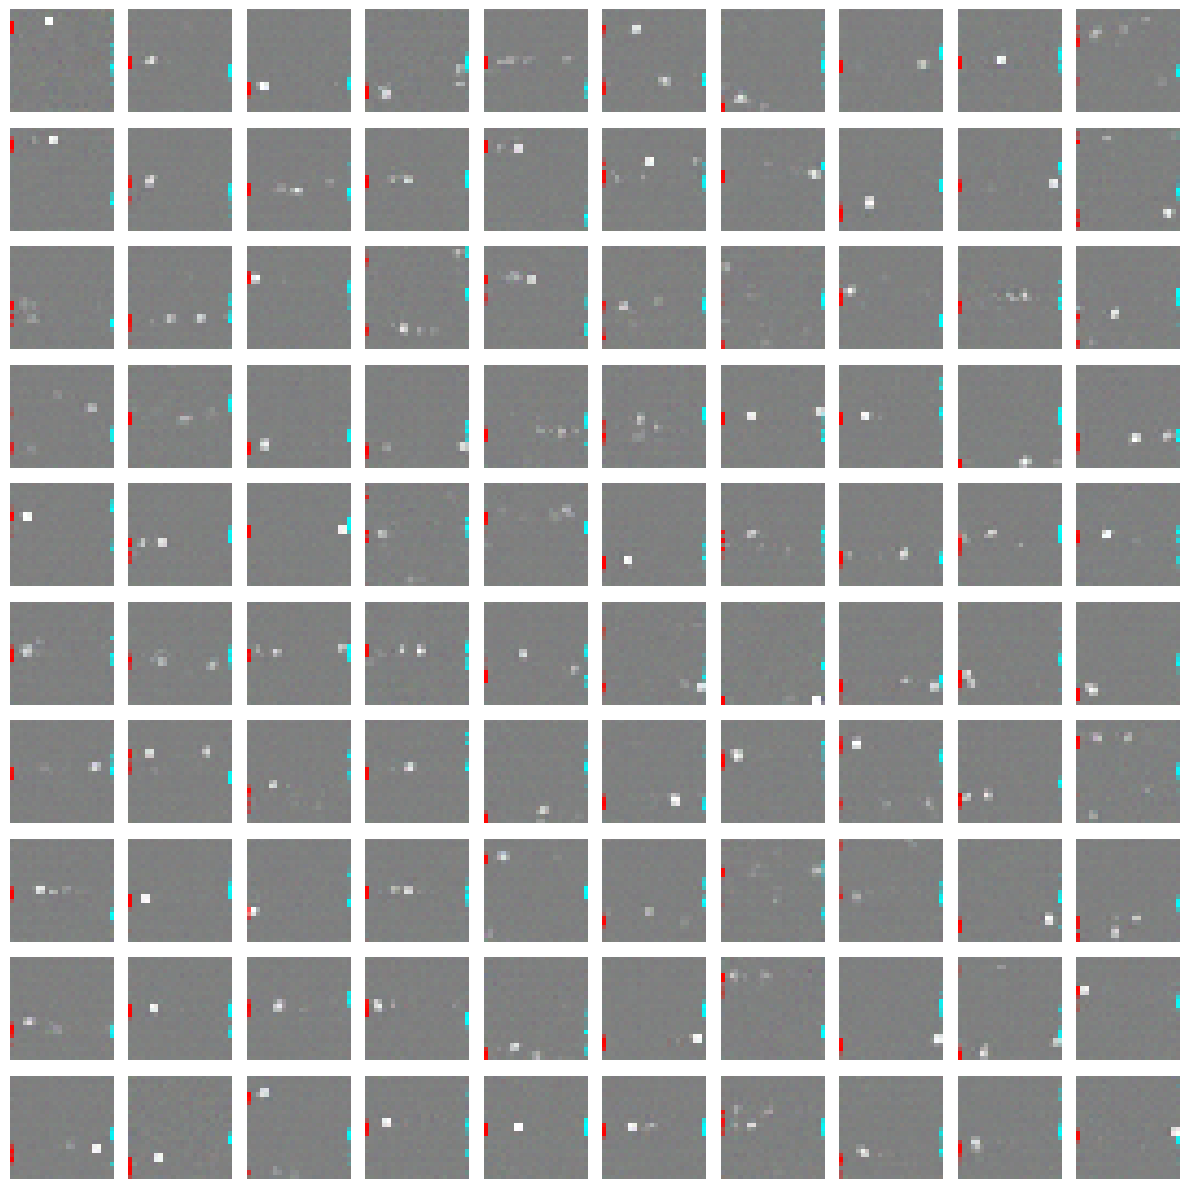

In [4]:
from src.trainers.diffusion_forcing import sample
import inspect
inspect.getsource(sample)
import matplotlib.pyplot as plt

z = sample(model, t.randn((100, 1, 3, 24, 24), device=model.device), actions=t.zeros(100, 1, dtype=t.int32, device=model.device), num_steps=4)
print(z.min(),z.max())
z = pred2frame(z)
print(z.min(),z.max())

num_images = 100
img_h, img_w = z.shape[-2], z.shape[-1]
grid_size = 10

fig, axes = plt.subplots(grid_size, grid_size, figsize=(12,12))
for idx in range(num_images):
    row = idx // grid_size
    col = idx % grid_size
    img = z[idx, 0].permute(1, 2, 0).cpu().numpy()  # shape: (24, 24, 3)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

In [5]:
def render_video(actions, start_frame = None, n_steps=8, cfg=0, negative_actions=None, clamp=True):
    frames = t.randn(1, 30, 3, 24, 24, device=model.device)
    if start_frame is not None:
        frames[:, 0] = start_frame
        start_idx = 1
    else:
        start_idx = 0
    for aidx in range(start_idx, actions.shape[1]):
        z = sample(model, frames, actions, num_steps=n_steps, cfg=cfg, negative_actions=negative_actions)
        frames[:, aidx:aidx+1] = z[:, aidx:aidx+1]
        if clamp:
            frames[:, aidx:aidx+1] = frames[:, aidx:aidx+1].clamp(-1, 1)
    return frames

In [6]:
model = t.compile(model)

In [ ]:
actions = t.tensor([[0]+29*[2]], dtype=t.int32, device=model.device)
negative_actions = t.tensor([[0]+29*[2]], dtype=t.int32, device=model.device)
z = render_video(actions, n_steps=4, cfg=0, negative_actions=None, clamp=True)
frames = pred2frame(z)

import matplotlib.pyplot as plt
import matplotlib.animation as animation

# z[0] shape: (num_frames, height, width, 3), where num_frames = frames.shape[1]
frames_np = frames[0].permute(0, 2, 3, 1).cpu().numpy()  # shape: (num_frames, height, width, 3)

fig, ax = plt.subplots()
im = ax.imshow(frames_np[0])
ax.set_title('Frame 0')

def animate(i):
    im.set_data(frames_np[i])
    ax.set_title(f'Frame {i}')
    return [im]

ani = animation.FuncAnimation(
    fig, animate, frames=frames_np.shape[0],
    interval=200, blit=True, repeat=True
)

plt.show()

# Optional: To save the gif uncomment below (requires pillow, install with `pip install pillow`)
from collections import Counter
# Majority vote over values in actions for the filename
if actions is not None:
    # Flatten actions tensor and convert to list
    action_vals = actions.flatten().tolist()
    majority_val = Counter(action_vals).most_common(1)[0][0]
    ani.save(f"sample_{majority_val}.gif", writer="pillow")
else:
    ani.save("sample_unknown.gif", writer="pillow")




 50%|█████     | 2/4 [00:01<00:01,  1.34it/s]

In [8]:
actions = t.tensor([6*[2]], dtype=t.int32, device="mps")
frames = render_video(actions, z[:, 0])
frames = pred2frame(frames)

import matplotlib.pyplot as plt
import matplotlib.animation as animation

# z[0] shape: (num_frames, height, width, 3), where num_frames = frames.shape[1]
frames_np = frames[0].permute(0, 2, 3, 1).cpu().numpy()  # shape: (num_frames, height, width, 3)

fig, ax = plt.subplots()
im = ax.imshow(frames_np[0])
ax.set_title('Frame 0')

def animate(i):
    im.set_data(frames_np[i])
    ax.set_title(f'Frame {i}')
    return [im]

ani = animation.FuncAnimation(
    fig, animate, frames=frames_np.shape[0],
    interval=200, blit=True, repeat=True
)

plt.show()

# Optional: To save the gif uncomment below (requires pillow, install with `pip install pillow`)
ani.save("sample_cont.gif", writer="pillow")

RuntimeError: PyTorch is not linked with support for mps devices